In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
from pathlib import Path
import functools
import itertools
from dataclasses import dataclass, fields

import pandas as pd
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import rcParams 

In [5]:
from lib import datawrap #E
from lib import bar # artist
from lib import color, position # encoders


#spath = Path("../../../draft/figures/code/")
rcParams['figure.dpi'] = 200

In [6]:
data = {'fruit': ['apple', 'orange', 'lemon', 'lime'], 
       'calories':[95, 67, 17, 20], 
       'juice':[True, True, False, False]}
df = pd.DataFrame(data)

In [7]:
data_bounds = {'calories':(17, 20), 'juice': [True], 'fruit':['orange']}
tau = datawrap.DataFrameWrapper(df)

In [8]:
tau.query({'calories':(17,20)})

[{'fruit': array(['apple', 'orange', 'lemon', 'lime'], dtype=object),
  'calories': array([95, 67, 17, 20], dtype=int64),
  'juice': array([ True,  True, False, False]),
  'k': array([0, 1, 2, 3], dtype=int64)}]

In [9]:
# should K be up front or last?
def constant_color(c):
     return lambda x: [mcolors.to_rgba(c) for _ in range(x)]

def constant_value(val):
     return lambda x: [val for _ in range(x)]

In [10]:
constant_color('k')(4)
constant_value(1)(6)

[1, 1, 1, 1, 1, 1]

In [12]:
# multivariate nu, make key always a tuple ([possibly data class])
fruitPos = position.Nominal({'apple': 0, 'orange': 2, 'lemon': 4, 'lime': 6})
juiceCol = color.Nominal({True: 'navy', False: 'purple'})
fruitCol = color.Nominal({'apple': 'xkcd:red', 'orange': 'orange', 
                         'lemon': 'gold', 'lime': 'lime'})

In [73]:
def make_V(ax, h=False):
    #include/set transdata as the position transforms
    # include the TransData class 
    # ax.transData
    def fruit(x):
        return ax.transData.transform(fruitPos(x))

    V = [('y', ('calories',), ax.transData.transform, None), 
            ('x', ('fruit',), fruit, fruitPos.inverse),
            ('floor', None,  constant_value(0), None), 
            ('width', None, constant_value(.8), None),
            ('edgecolor', ('juice',), juiceCol, juiceCol.inverse),
            ('facecolor', ('fruit',), fruitCol, fruitCol.inverse),
            ('linewidth', None, constant_value(5), None),
             ('linestyle', None, constant_value((0, None)), None)]
    if h:
        V[0] = ('x', *V[0][1:])
        V[1] = ('y', *V[1][1:])
    return V

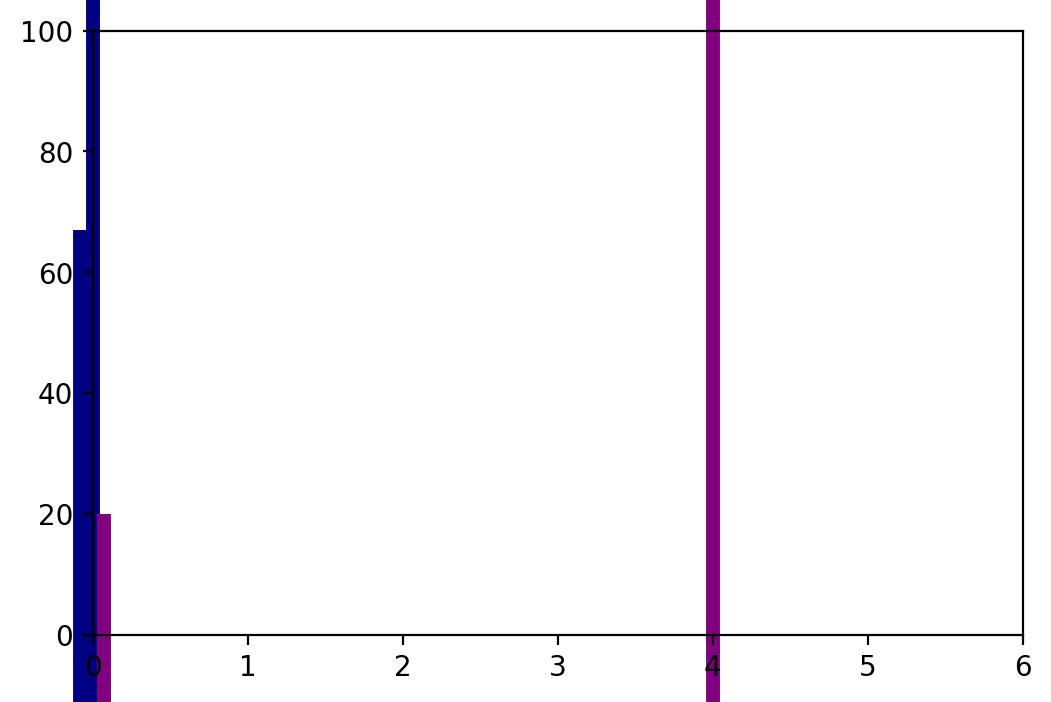

In [74]:
fig, ax = plt.subplots()
dbar = bar.Bar()
for (p, f, nu, nu_inv) in make_V(ax):
  pbar = dbar.compose_with_nu(p, f, nu, nu_inv)
A = bar.TopologicalArtist(pbar).compose_with_tau(tau)
ax.set(xlim=(0,6), ylim=(0, 100))
axesArtist = bar.GenericArtist(A)
ax.add_artist(axesArtist)

[(-1.0, 8.0), (0.0, 100.0)]

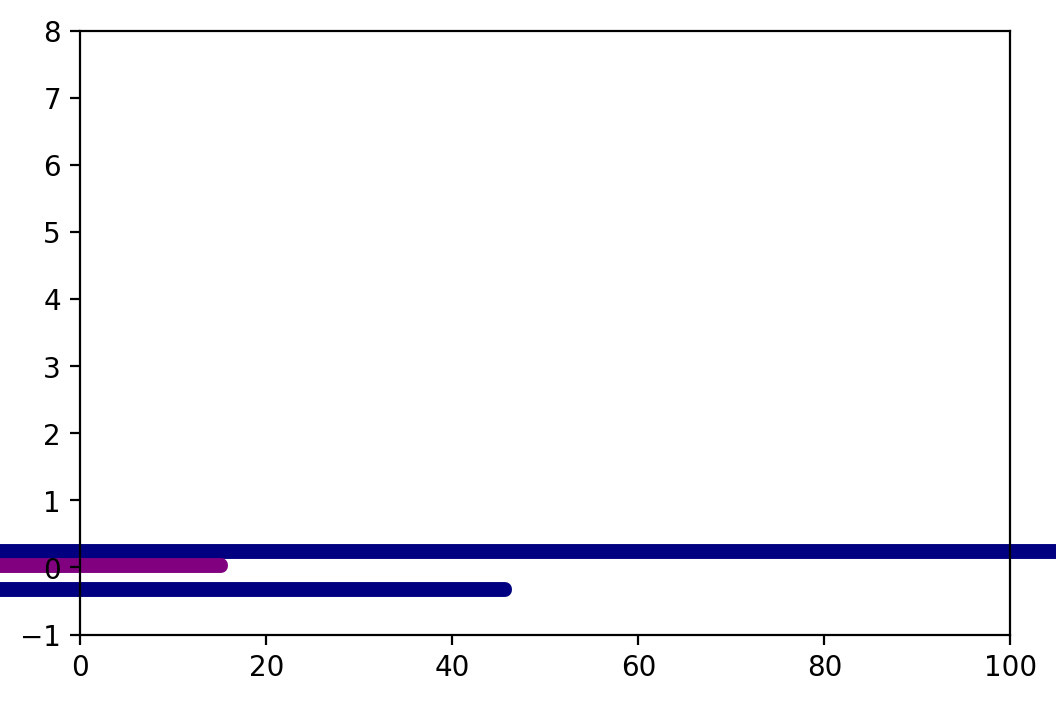

In [75]:
dbarh = bar.BarH()
for (pi, fi, nui, nu_inv) in make_V(ax, h=True):
  pbarh = dbarh.compose_with_nu(pi, fi, nui)
Ah = bar.TopologicalArtist(pbarh).compose_with_tau(tau)
fig, ax = plt.subplots()
ax.add_artist(bar.GenericArtist(Ah))
ax.set(ylim=(-1,8), xlim=(0, 100))

In [49]:
from matplotlib.backends.backend_agg import RendererAgg
renderer = RendererAgg(500, 400, 100)
axesArtist.get_screen_bounds_to_data_bounds(renderer)

({'x': ['apple', 'lime'], 'y': (0.0, 100.0)}, 100)

In [ ]:
fig, ax = plt.subplots()
axesArtist = bar.GenericArtist(A)
ax.add_artist(axesArtist)
ax.set(xlim=(-1,8), ylim=(0, 100))

In [77]:
ax.get_ylim()

(-1.0, 8.0)